## This file is to test how the TrOCR works when the outputs of the pretrained Unet are passed as input to the Transformer


In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# Load pretrained TrOCR model & processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam




def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

model=unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,031,685 (118.38 MB)

 Trainable params: 31,031,685 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
unet_model = unet()
unet_model.load_weights("/content/drive/MyDrive/human_ai_folder/unet.weights.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_text_regions(unet_model, image_path):
    """Detect text regions in an image using U-Net and return cropped text regions."""

    # Load grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original = cv2.imread(image_path)

    # Apply thresholding (invert so text is white, background black)
    _, binarized_img = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Resize to match U-Net input shape
    binarized_img_resized = cv2.resize(binarized_img, (512, 512))
    binarized_img_resized = np.expand_dims(binarized_img_resized, axis=-1)  # Add channel dimension

    # Predict segmentation mask using U-Net
    pred_mask = unet_model.predict(np.expand_dims(binarized_img_resized, axis=0))[0]
    pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove channel dimension
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Threshold mask

    # Resize mask back to original size
    pred_mask_resized = cv2.resize(pred_mask, (original.shape[1], original.shape[0]))

    # Apply dilation to merge fragmented text regions
    kernel = np.ones((5,5), np.uint8)
    dilated_mask = cv2.dilate(pred_mask_resized, kernel, iterations=2)

    # Find contours (text regions) in the dilated mask
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cropped_text_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_text = original[y:y+h, x:x+w]
        cropped_text_regions.append(cropped_text)

    return cropped_text_regions, dilated_mask





1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


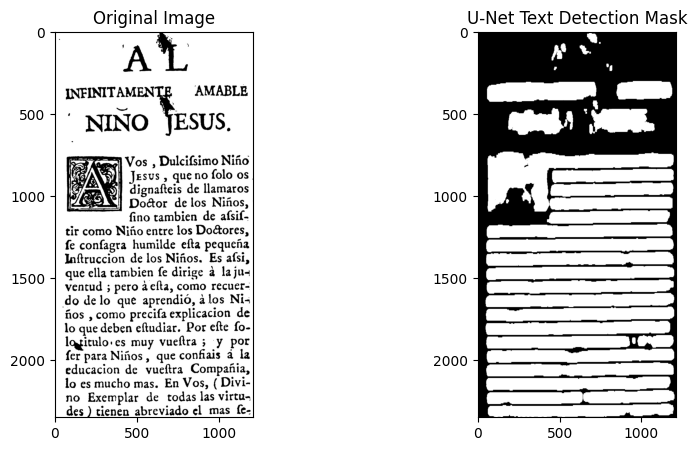

In [48]:
test_image_path = "/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg"

# Step 1: Detect text using U-Net
cropped_texts, text_mask = detect_text_regions(unet_model, test_image_path)

# Step 2: Visualize detected text regions
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(test_image_path)[..., ::-1])
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(text_mask, cmap="gray")
plt.title("U-Net Text Detection Mask")
plt.show()


In [21]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import cv2
from PIL import Image

# Load TrOCR processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [37]:
def recognize_text_with_trocr(cropped_images):
    """Pass cropped text regions to TrOCR and return extracted text."""

    extracted_texts = []

    for i, cropped_img in enumerate(cropped_images):
        # Convert OpenCV image to PIL format
        pil_image = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

        # Preprocess and move to GPU (if available)
        pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

        # Predict text
        with torch.no_grad():
            generated_ids = model.generate(pixel_values)

        # Decode output text
        recognized_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        extracted_texts.append(recognized_text)

        print(f"📝 Recognized Text [{i+1}]: {recognized_text}\n")

    return extracted_texts


In [38]:
# Load a test image
test_image_path = "/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg"

# Step 1: Detect text regions using U-Net
cropped_texts, text_mask = detect_text_regions(unet_model, test_image_path)

# Step 2: Recognize text using TrOCR
recognized_texts = recognize_text_with_trocr(cropped_texts)

# Step 3: Display results
for idx, text in enumerate(recognized_texts):
    print(f"Extracted Text {idx+1}: {text}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
📝 Recognized Text [1]: DES ) TIONEN ABREVIADO EL MAS FE-

📝 Recognized Text [2]: NO EXEMPLAR DE

📝 Recognized Text [3]: TODAS LAS VIRTU-

📝 Recognized Text [4]: LO ES MUCHO MAS. EN VOS, ( DIVI.

📝 Recognized Text [5]: EDUCACION DE VUEFRA COMPANIA,

📝 Recognized Text [6]: TER PARA NINOS, QUE CONDAIS A LA

📝 Recognized Text [7]: 1

📝 Recognized Text [8]: LOTITULO.ES MUY VUEFRA ;

📝 Recognized Text [9]: Y POR

📝 Recognized Text [10]: TO QUE DEBEN EFINDIAF. POR EFTE TO.

📝 Recognized Text [11]: ROS , COMO PRECIPA EXPLCACION DE

📝 Recognized Text [12]: DO DE LO QUE APENDIO, A LOS NI-

📝 Recognized Text [13]: VENTUD ; PERO AERIA, COMO RECUER-

📝 Recognized Text [14]: QUE EILA TAMBLEN FE DIFIGE A LA JU-

📝 Recognized Text [15]: LATRUCCION DE LOS NINOS. ES AISI,

📝 Recognized Text [16]: RE CONFAGRA HUMILDE ERA PEQUERA

📝 Recognized Text [17]: FIR COMO NINO ENTER LOS DOCTORES,

📝 Recognized Text [18]: FINO TAMBIEN DE ASSIT-

📝 Recognized Text [19]: 4

📝 Recog

In [55]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,610 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [57]:
import pytesseract

def extract_text(image_path):
    img=cv2.imread(image_path)
    text=pytesseract.image_to_string(img)
    return text

image_path=test_image_path
ocr_result=extract_text(image_path)
print("🔹 OCR Output:\n", ocr_result)

🔹 OCR Output:
  

ah Acer] VOS » Dulcifsimo Nifio
YAN Sy || Jesus , que no folo os ,
Gye es)| dignafteis de llamaros
Door de los Ninos, '
fino tambien de afsif-
tir como Nijio entre los Dodtores,
fe confagra humilde efta pequena
Inftruccion de los Nifios. Es afsi,
que ella tambien fe dirige a laju-
ventud ; pero aefta, como recuer-
do de lo que aprendio, alos Ni-
fos , como precifa explicacion de
lo que deben eftudiar. Por efte fo-
logitulo:es muy vueftra ; y por
fer para Nifios, que confiais a la
educacion de vueftra Compania,
lo es mucho mas. En Vos, ( Divi-
no Exemplar de todas las virtu-
des ) tienen abreviado el mas {e-

 
  



Implementing Pyteseract to detect text and then pass those text to Trocr model to see how the text recognition works on trocr pretrained model

In [60]:
import cv2
import pytesseract
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load Image
image_path = "/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [62]:
# Perform OCR with bounding box extraction
data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
print(data)

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

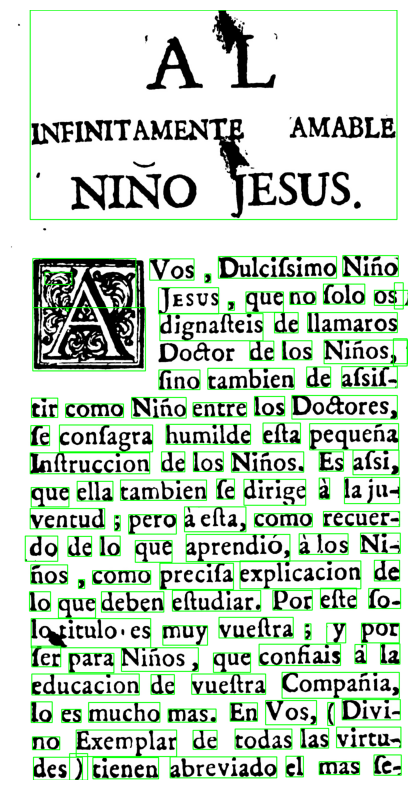

In [64]:
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:  # Ignore low-confidence detections
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [63]:


def process_text_regions(image, data):
    extracted_text = ""

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            cropped_region = image[y:y+h, x:x+w]
            pil_img = Image.fromarray(cropped_region).convert("RGB")

            # Process with TrOCR
            pixel_values = processor(pil_img, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            extracted_text += decoded_text + " "

    return extracted_text

# Extract and recognize text
final_text = process_text_regions(gray, data)
print("Extracted Text:")
print(final_text)

Extracted Text:
'S SR VOS : DULCISIMO NINO : 3 1 JESUS : QUE NO TOLO OS : GST 5 DIGNAFEIS DE ILAMARDS DOOTOR DE LOS NINOS, : INO TAMBIEN DE AISIF- CIT COMO NINO ENTRE LOS DOSTORES, TE CONFAGRA HUMILDE ETTA PEQUENA INSTRUCTION DE IOS NINOS. ES AISI, QUE ELLA TAMBIEN TE DIFICE 2 LAJU- VENTUD : PERO AEFTA, COMO RECUER- DO DE 10 QUE APRENDIO, ALOS NI- NOS > COMO PRECIFA EXPLICACION DE 10 QUE DEBEN REFUDIAR. POR EFTE TO- IO TITULO.ES MUY VUEFRA : Y POR TER PARA NINOS , QUE CONRAIS A. 1 EDUCACION DE VUEFRA COMPANIA, 10 CS MUCHO MAS. EN VOS, ( DIVI- NO EXEMPLAR DE TODAS LAS VIRTU- DES ) ) TIENEN ABREVIADO CL MAS TE- 


In [68]:
pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.2 MB/s eta 0:00:00


In [70]:
pip install jiwer

In [71]:
import pytesseract
import cv2
import Levenshtein
from jiwer import wer



transcript_path = "/content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt"
with open(transcript_path, "r", encoding="utf-8") as f:
    ground_truth_text = f.read().strip()

cer = Levenshtein.distance(final_text, ground_truth_text) / max(len(ground_truth_text), 1)
wer_value = wer(ground_truth_text, final_text)

In [72]:
print("\nGround Truth Transcript:\n", ground_truth_text)
print(f"\nCER (Character Error Rate): {cer:.4f}")
print(f"WER (Word Error Rate): {wer_value:.4f}")


Ground Truth Transcript:
 Al
INFINITAMENTE AMABLE
NIÑO JESUS.
A Vos, Dulcissimo Niño
JESUS, que no solo os
dignasteis de llamaros
Doctor de los Niños, 
sino también de assis-
tir como Niño entre los Doctores, 
se consagra humilde esta pequeña
Instrucción de los Niños. Es assi, 
que ella también se dirige a la ju-
ventud; pero a esta, como recuer-
do de lo que aprendió, a los Ni-
ños, como precisa explicacion de 
lo que deben estudiar. Por este so-
lo titulo es muy vuestra; y por
ser para Niños, que confiais a la
educacion de vuestra Compañia, 
lo es mucho mas. En Vos, (Divi-
no Exemplar de todas las virtu-
des) tienen abreviado el mas se-

CER (Character Error Rate): 0.8032
WER (Word Error Rate): 1.2474


In [80]:
image_path = "/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_2.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [81]:
data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
print(data)

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 3, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4,

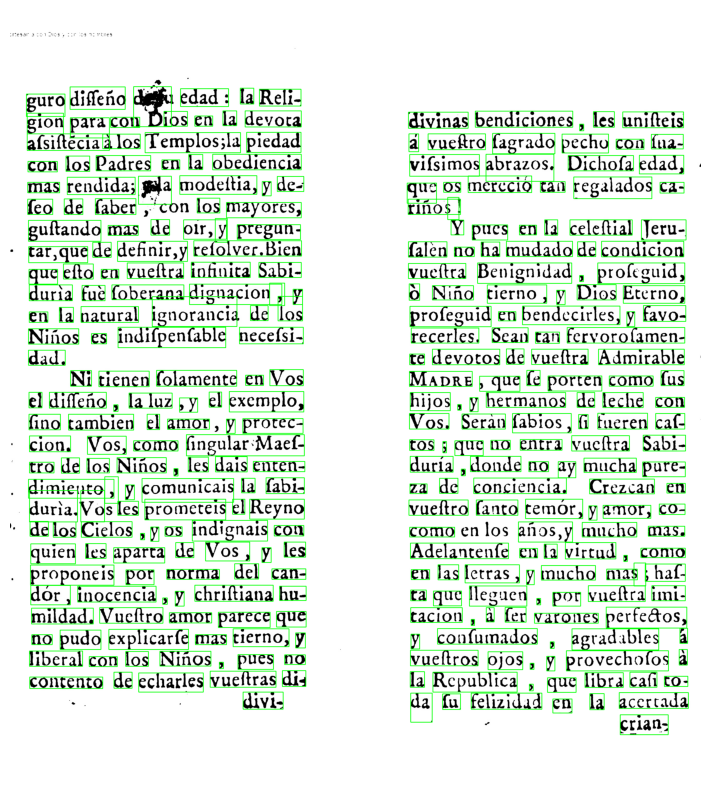

In [82]:
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:  # Ignore low-confidence detections
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [83]:
def process_text_regions(image, data):
    extracted_text = ""

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            cropped_region = image[y:y+h, x:x+w]
            pil_img = Image.fromarray(cropped_region).convert("RGB")

            # Process with TrOCR
            pixel_values = processor(pil_img, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            extracted_text += decoded_text + " "

    return extracted_text

# Extract and recognize text
final_text = process_text_regions(gray, data)
print("Extracted Text:")
print(final_text)

Extracted Text:
GURO DIFENO 6 EDAD : IA RELI- TION PARA COM IOS EN 1 DEVOTA AISITECIA A ALOS TEMPLOS;LA PIEDAD CON LOS PADRES EN 1A OBEDIENCIA MAS RENDIDA; SPLA MODETTIA, Y DE- TEO DE TABLEER , CON LOS MAYORES, GUITANDO MAS DE OLR, Y Y PREGUN- TAR,QUE DE DEFINIR,Y REVOLVER.BIEN QUE EFTO EN VUEITRA INFINITA SABI- DURIA FUE COBERANA DIGNACION , : Y EN LA NATURAL IGNORANCIA DE LOS NINOS ES INDIFPENTABLE RECEISI- DAD. NI TIENEN TOTALMENTE EN VOS EL DIFENO : IA LUX > Y EL EXEMPLO, GINO TAMBIEN EL AMOR Y PROTEC- CION. VOS, COMO GINGULAR MASF- TRO DE IOS NINOS : IES DAIS ENTEN- DIMIENTO , > Y COMUNICAIS 1A TABLE DURIA. VO IES PROMETEIS EL REYNO DE IOS CILOS : Y OS INDIGNAIS COUN QUIEN IES APARTA DE VOS , Y IES PROPONEIS POR NORMA DEL CAN- dOR, INOCENCIA > Y CHRIFTIANA HU- MILOAD. VUEITRO AMOR PARECE QUE NO PUDO EXPLICARTE MAS TIERNO, Y LIBERAL CON LOS NINOS : PUES NO CONTENTO DE ECHARLES VUEITRAS DIA : 4 DIVI- DIVINAS BENDICIONES : IES UNITEIS 2 VUEFRO PAGRAJO PECHO COD TRA- VISIMOS ABRAZOS. 

In [84]:
transcript_path = "/content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page2.txt"
with open(transcript_path, "r", encoding="utf-8") as f:
    ground_truth_text = f.read().strip()

cer = Levenshtein.distance(final_text, ground_truth_text) / max(len(ground_truth_text), 1)
wer_value = wer(ground_truth_text, final_text)

In [85]:
print("\nGround Truth Transcript:\n", ground_truth_text)
print(f"\nCER (Character Error Rate): {cer:.4f}")
print(f"WER (Word Error Rate): {wer_value:.4f}")


Ground Truth Transcript:
 guro disseño de su edad: la Reli-
gion para con Dios en la devota
assistencia a los Templos; la piedad
con los Padres en la obediencia
mas rendida; y la modestia, y de-
seo de saber, con los mayores, 
gustando mas de oir, y pregun-
tar, que de definir, y resolver. Bien
que esto en vuestra infinita Sabi-
duria fue soberana dignacion, y
en la natural ignorancia de los
Niños es indispensable necessi-
dad. 
Ni tienen solamente en Vos 
el disseño, la luz, y el exemplo, 
sino tambien el amor, y protec-
cion. Vos, como singular Maes-
tro de los Niños, les dais enten-
dimiento, y comunicais la sabi-
duria. Vos les prometeis el Reyno
de los Cielos, y os indignais con
quien les aparta de Vos, y les
proponeis por norma del can-
dor, inocencia, y christiana hu-
mildad. Vuestro amor parece que
no pudo explicarse mas tierno, y
liberal con los Niños, pues no
contento de echarles vuestras di-
vinas bendiciones, les unisteis
a vuestro sagrado pecho con sua-
vissimos abrazos. 